# Introduction to Causal Abstraction, Interchange Intervention Training, Distributed Alignment Search 

In [1]:
__author__ = "Atticus Geiger"

## Contents

1. [The hierarchical equality task](#The-hierarchical-equality-task)
    1. [An Algorithm that Solves the Equality Task](#An-Algorithm-that-Solves-the-Equality-Task)
        1. [The algorithm with no intervention](#The-algorithm-with-no-intervention)
        1. [The algorithm with an intervention](#The-algorithm-with-an-intervention)
        1. [The algorithm with an interchange intervention](#The-algorithm-with-an-interchange-intervention)
    1. [Hand Crafting an MLP to Solve Hierarchical Equality](#Hand-Crafting-an-MLP-to-Solve-Hierarchical-Equality)        
    1. [Training an MLP to Solve Hierarchical Equality](#Training-an-MLP-to-Solve-Hierarchical-Equality)
1. [Causal abstraction Analysis](#Causal-abstraction)
    1. [Basic intervention: zeroing out part of a hidden layer](#Basic-intervention:-zeroing-out-part-of-a-hidden-layer)
    1. [An interchange intervention](#An-interchange-intervention)
    1. [Alignment](#Alignment)
    1. [Evaluating an Alignment](#Evaluation)
1. [Interchange Intervention Training (IIT)](#Interchange-Intervention-Training-(IIT))
1. [Distributed Alignment Search (DAS)](#Distributed-Alignment-Search-(DAS))

## Set-up

This notebook is a hands-on introduction to __causal abstraction analysis__ and __interchange intervention training__ with neural networks.

In causal abstraction analysis, we assess whether trained models conform to high-level causal models that we specify, not just in terms of their input–output behavior, but also in terms of their internal dynamics. The core technique is the __interchange intervention__, in which a causal model is provided an input and then intermediate variables are fixed to take on the values they would have for a second input.

To motivate and illustrate these concepts, we're going to focus on a hierarchical equality task, building on work by [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968).

In [2]:
import sys
sys.path.append('C:\\Users\\attic\\Documents\\GitHub\\InterchangeInterventions')

In [3]:
import torch
import random
import copy
import itertools
import numpy as np
import utils
from causal_model import CausalModel
from sklearn.metrics import classification_report
from models.LIM_deep_neural_classifier import LIMDeepNeuralClassifier
import causalmodels.equality
from trainer import LIMTrainer

C:\Users\attic\anaconda3\envs\bigkid\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
utils.fix_random_seeds()
embedding_dim = 2
number_of_entities = 1000

## The hierarchical equality task

This section builds on results presented in [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968). We will use a hierarchical equality task ([Premack 1983](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/7DF6F2D22838F7546AF7279679F3571D/S0140525X00015077a.pdf/div-class-title-the-codes-of-man-and-beasts-div.pdf)) to present interchange intervention training (IIT). 

We define the hierarchical equality task as follows: The input is two pairs of objects and the output is **True** if both pairs contain the same object or if both pairs contain different objects and **False** otherwise.  For example, `AABB` and `ABCD` are both labeled **True**, while `ABCC` and `BBCD` are both labeled **False**. 

## An Algorithm that Solves the Equality Task

Let $\mathcal{A}$ be the simple tree-structured algorithm that solves this task by applying a simple equality relation three times: Compute whether the first two inputs are equal, compute whether the second two inputs are equal, then compute whether the truth-valued outputs of these first two computations are equal. 

And here's a Python implementation of $\mathcal{A}$ that supports the interventions we'll want to do:

In [5]:
variables =  ["W", "X", "Y", "Z", "WX", "YZ", "O"]

reps = [utils.randvec(embedding_dim) for _ in range(number_of_entities)]
values = {variable:reps for variable in ["W","X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {"W":[],"X":[], "Y":[], "Z":[], 
           "WX":["W", "X"], "YZ":["Y", "Z"], 
           "O":["WX", "YZ"]}

def FILLER():
    return reps[0]

functions = {"W":FILLER,"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "WX": lambda x,y: np.array_equal(x,y), 
             "YZ":lambda x,y: np.array_equal(x,y), 
             "O": lambda x,y: x==y}

pos = {"W":(0.2,0),"X":(1,0.1), "Y":(2,0.2), "Z":(2.8,0), 
           "WX":(1,2), "YZ":(2,2), 
           "O":(1.5,3)}

equiv_classes = {}

equality_model = CausalModel(variables, values, parents, functions, pos = pos)

Here's a visual depiction of the algorithm:

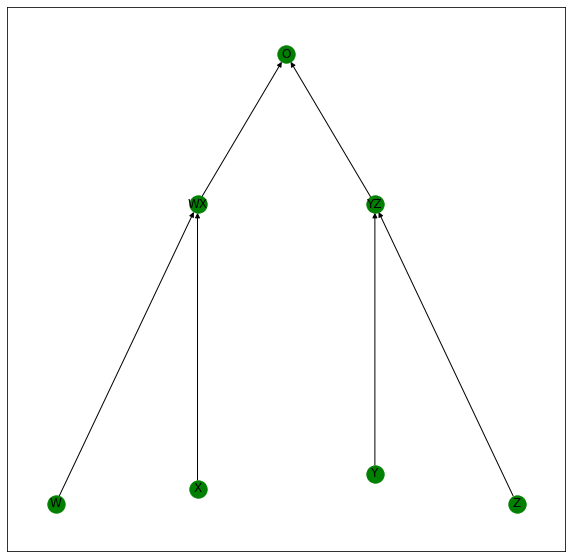

Timesteps: {'W': 0, 'X': 0, 'Y': 0, 'Z': 0, 'WX': 1, 'YZ': 1, 'O': 3}


In [6]:
equality_model.print_structure()
print("Timesteps:", equality_model.timesteps)

### The algorithm with no intervention

Let's first observe the behavior of the algorithm when we provide the input `BBCD` with no interventions. Here is a visual depiction:

No intervention:
 defaultdict(None, {'W': array([ 0.1394268 , -0.47498924]), 'X': array([ 0.1394268 , -0.47498924]), 'Y': array([-0.22497068, -0.27678926]), 'Z': array([ 0.39217957, -0.41306117]), 'WX': True, 'YZ': False, 'O': False}) 



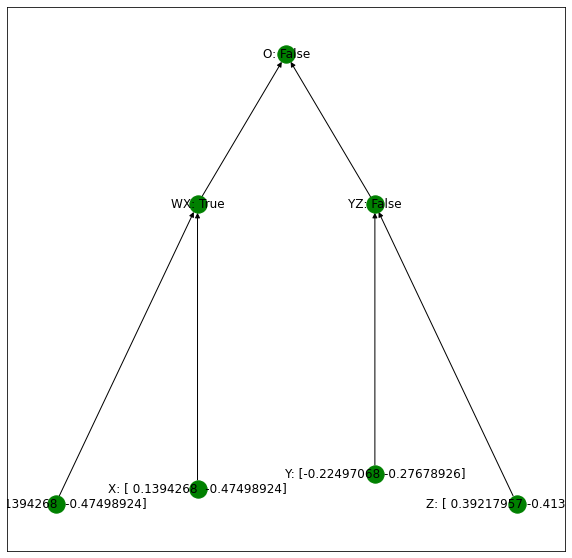

In [7]:
setting = equality_model.run_forward({"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3]})
print("No intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### The algorithm with an intervention

Let's now see the behavior of the algorithm when we provide the input `BBCD` with an intervention setting **WX** to **False**. First, a visual depiction:

<img src="fig/IIT/PremackIntervention.png" width="500"/>

And then the same computation with `compute_A`:

Intervention setting WX to TRUE:



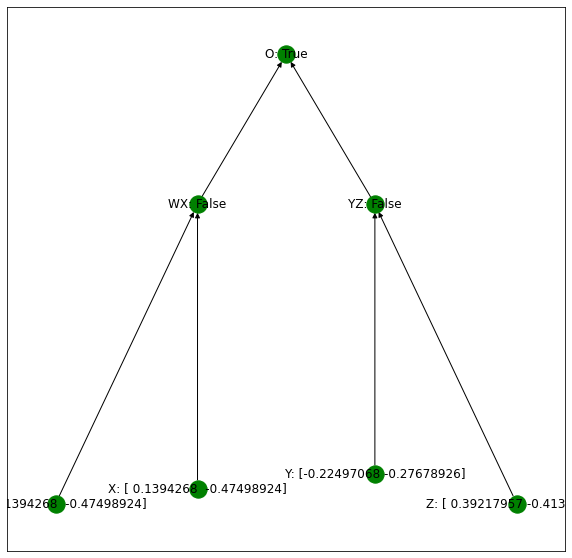

In [8]:
print("Intervention setting WX to TRUE:\n", )
equality_model.print_setting(equality_model.run_forward({"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3], "WX":False}))

Notice that, in this example, even though the left two inputs are not the same, the intervention has changed the intermediate prediction for those two inputs from **False** to **True**, and thus the algorithm outputs **True**, since its output is determined by **WX** and **YZ**.

### The algorithm with an interchange intervention

Finally, let's observe the behavior of the algorithm when we provide the base input `BBCD` with an intervention setting **WX** to be the value it would be for the source input `ABCC`.

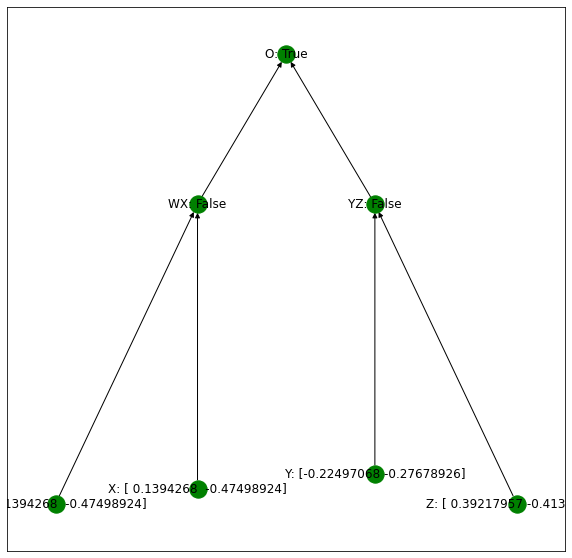

In [9]:
base = {"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3]}
source = {"W":reps[0], "X":reps[1], "Y":reps[2], "Z":reps[2]}
setting = equality_model.run_interchange(base, {"WX":source})
equality_model.print_setting(setting)

# Hand Crafting an MLP to Solve Hierarchical Equality

In [10]:
n_examples = 100000

X, y = equality_model.generate_factual_dataset(n_examples,equality_model.sample_input_tree_balanced)

In [11]:
handcrafted = LIMDeepNeuralClassifier(
    hidden_dim=embedding_dim*4, 
    hidden_activation=torch.nn.ReLU(), 
    num_layers=2,
    input_dim=embedding_dim*4,
    n_classes=2
    )
handcrafted_trainer = LIMTrainer(
    handcrafted,
    warm_start=True,
    max_iter=10,
    batch_size=64,
    n_iter_no_change=10000,
    shuffle_train=False,
    eta=0.001)

In [12]:
handcrafted.labeled_layers[0]["model"].linear.weight = torch.nn.Parameter(torch.FloatTensor([[1,0,-1,0,0,0,0,0],
                                                                                             [0,1,0,-1,0,0,0,0],
                                                                                             [-1,0,1,0,0,0,0,0],
                                                                                             [0,-1,0,1,0,0,0,0],
                                                                                             [0,0,0,0,1,0,-1,0],
                                                                                             [0,0,0,0,0,1,0,-1],
                                                                                             [0,0,0,0,-1,0,1,0],
                                                                                             [0,0,0,0,0,-1,0,1]]))
handcrafted.labeled_layers[0]["model"].linear.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))

handcrafted.labeled_layers[1]["model"].linear.weight = torch.nn.Parameter(torch.FloatTensor([[1, 0,-1,0, 0,0,0,1],
                                                                                             [1, 0,-1,0, 0,0,0,1],
                                                                                             [1, 0,-1,0, 0,0,0,1],
                                                                                             [1, 0,-1,0, 0,0,0,1],
                                                                                             [-1,0, 1,0, 1,0,0,0],
                                                                                             [-1,0, 1,0, 1,0,0,0],
                                                                                             [-1,0, 1,0, 1,0,0,0],
                                                                                             [-1,0, 1,0, 1,0,0,0]]).transpose(0,1))
handcrafted.labeled_layers[1]["model"].linear.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))

handcrafted.labeled_layers[2]["model"].weight = torch.nn.Parameter(torch.FloatTensor([[1,0],
                                                                                             [0,0],
                                                                                             [1,0],
                                                                                             [0,0],
                                                                                             [-0.5,0],
                                                                                             [0,0],
                                                                                             [0,0],
                                                                                             [-0.5,0]]).transpose(0,1))
handcrafted.labeled_layers[2]["model"].bias = torch.nn.Parameter(torch.FloatTensor([-0.001,0]))

In [13]:
x = torch.FloatTensor([0.11, 0.23,0.11, 0.23,0.91, 1.84,-0.09, -1.16])
print(handcrafted.model_layers[0](x))
print(handcrafted.model_layers[1](handcrafted.model_layers[0](x)))
print(handcrafted.model_layers[2](handcrafted.model_layers[1](handcrafted.model_layers[0](x))))
print(handcrafted(x))

tensor([0., 0., 0., 0., 1., 3., 0., 0.], grad_fn=<ReluBackward0>)
tensor([0., 0., 4., 0., 4., 0., 0., 0.], grad_fn=<ReluBackward0>)
tensor([1.9990, 0.0000], grad_fn=<AddBackward0>)
tensor([1.9990, 0.0000], grad_fn=<AddBackward0>)


In [14]:

h  = torch.matmul(x.cpu(), handcrafted.labeled_layers[0]["model"].linear.weight.cpu()) + handcrafted.labeled_layers[0]["model"].linear.bias.cpu()
print(h)
hactive = torch.relu(h)
print(hactive)
h2 = torch.matmul(hactive.cpu(), handcrafted.labeled_layers[1]["model"].linear.weight.cpu().transpose(0,1)) + handcrafted.labeled_layers[1]["model"].linear.bias.cpu()
print(h2)
hactive2 = torch.relu(h2)
print(hactive2)
logits = torch.matmul(handcrafted.labeled_layers[2]["model"].weight.cpu(),hactive2.cpu()) + handcrafted.labeled_layers[2]["model"].bias.cpu()
print(logits)
if logits[0] >= logits[1]:
    print("True")
else:
    print("False")

tensor([ 0.,  0.,  0.,  0.,  1.,  3., -1., -3.], grad_fn=<AddBackward0>)
tensor([0., 0., 0., 0., 1., 3., 0., 0.], grad_fn=<ReluBackward0>)
tensor([-4.,  0.,  4.,  0.,  4.,  0.,  0.,  0.], grad_fn=<AddBackward0>)
tensor([0., 0., 4., 0., 4., 0., 0., 0.], grad_fn=<ReluBackward0>)
tensor([1.9990, 0.0000], grad_fn=<AddBackward0>)
True


In [15]:
preds = handcrafted_trainer.predict(X, device="cpu")

print("Train Results")
print(classification_report(y, preds.cpu()))

Train Results
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     49794
         1.0       1.00      0.91      0.95     50206

    accuracy                           0.95    100000
   macro avg       0.96      0.95      0.95    100000
weighted avg       0.96      0.95      0.95    100000



# Training an MLP to Solve Hierarchical Equality

We've now seen how interventions work in our high-level causal model. We turn now to doing parallel work in our neural network, which will be a fully-connected feed-forward neural network with three hidden layers. The following code simply extends `TorchDeepNeuralClassifier` with a method `retrieve_activations` that supports interventions on PyTorch computation graphs:

The module `iit` provides some dataset functions for equality learning. Here we define a simple an equality dataset:

The examples in this dataset are 8-dimensional vectors: the concatenation of 4 2-dimensional vectors. Here's the first example with its label:

In [16]:
X[0], y[0]

(tensor([ 0.4766,  0.0246,  0.0902,  0.3697, -0.4805,  0.4291,  0.1735,  0.0444]),
 tensor([1.]))

The label for this example is determined by whether the equality value for the first two inputs matches the equality value for the second two inputs:

In [17]:
left = torch.equal(
    X[0][: embedding_dim],
    X[0][embedding_dim: embedding_dim*2])

left

False

In [18]:
right = torch.equal(
    X[0][embedding_dim*2: embedding_dim*3],
    X[0][embedding_dim*3: ])

right

False

In [19]:
int(left == right)

1

Let's see how our model does out-of-the-box on this task:

In [20]:
LIM = LIMDeepNeuralClassifier(
    hidden_dim=embedding_dim*4, 
    hidden_activation=torch.nn.ReLU(), 
    num_layers=3,
    input_dim=embedding_dim*4,
    n_classes=2
    )
LIM_trainer = LIMTrainer(
    LIM,
    warm_start=True,
    max_iter=10,
    batch_size=64,
    n_iter_no_change=10000,
    shuffle_train=False,
    eta=0.001)

In [21]:
_ = LIM_trainer.fit(X, y)

Finished epoch 10 of 10; error is 155.06558223068714

This neural network achieves near perfect performance on its train set:

In [22]:
preds = LIM_trainer.predict(X, device="cpu")


print("Train Results")
print(classification_report(y, preds.cpu()))

Train Results
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     49794
         1.0       0.98      0.97      0.97     50206

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



And it generalizes perfectly to a test set consisting of distinct vectors:

In [23]:
variables =  ["W", "X", "Y", "Z", "WX", "YZ", "O"]

number_of__test_entities = 100

reps = [utils.randvec(embedding_dim).round(2)  for _ in range(number_of__test_entities)]
values = {variable:reps for variable in ["W","X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {"W":[],"X":[], "Y":[], "Z":[], 
           "WX":["W", "X"], "YZ":["Y", "Z"], 
           "O":["WX", "YZ"]}

def FILLER():
    return reps[0]

functions = {"W":FILLER,"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "WX": lambda x,y: np.array_equal(x,y), "YZ":lambda x,y: np.array_equal(x,y), 
             "O": lambda x,y: x==y}

pos = {"W":(0,0),"X":(1,0.1), "Y":(2,0.2), "Z":(3,0), 
           "WX":(1,2), "YZ":(2,2), 
           "O":(1.5,3)}

test_equality_model = CausalModel(variables, values, parents, functions, pos = pos)

In [24]:
X_test, y_test = test_equality_model.generate_factual_dataset(10000,equality_model.sample_input_tree_balanced)
print("Test Results")

test_preds = LIM_trainer.predict(X_test, device="cpu")

print(classification_report(y_test, test_preds.cpu()))

Test Results
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      5067
         1.0       0.97      0.97      0.97      4933

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Does it implement our high-level model of the problem, though?

# Causal abstraction

To recap:

1. We defined a **high-level causal model** (a tree-structured algorithm) that solves the hierarchical equality task.

1. We trained a **low-level fully connected neural network** that seeks to solv the hierarchical equality task.

1. We peformed illustrative interventions on both these networks to begin to get a feel for whether the high-level model is an abstraction of the lower-level neural one.

The formal theory of **causal abstraction** describes the conditions that must hold for the high-level tree structured algorithm to be a **simplified and faithful description** of the neural network. 

In essence: an high-level model is a causal abstraction of a neural network if and only if for all base and source inputs, the algorithm and network provides the same output, for some alignment between these two models.

Below, we define an alignment between the neural network and the algorithm and a function to compute the **interchange intervention accuracy** (II accuracy) for a high-level variable: the percentage of aligned interchange interventions that the network and algorithm produce the same output on. When the II accuracy is 100%, the causal abstraction relation holds between the network and a simplified version of the algorithm where only one high-level variable exists.

## Basic intervention: zeroing out part of a hidden layer

To begin to build towards the full interchange intervention, let's consider a simpler intervention, where we zero out the first `embedding_dim` neurons in the first hidden layer.

Our basic inputs are random vectors:

In [25]:
a = X[0][: embedding_dim]
b = X[1][: embedding_dim]
c = X[2][: embedding_dim]

X_same_different = torch.cat((a, a, b, c)).unsqueeze(0)

X_different_same = torch.cat((a, b, c, c)).unsqueeze(0)

And here we define two different inputs for use in later examples. We'll use training examples so that we are sure to see the full logic of these interventions; the next section will consider test examples in the context of a full abstraction analysis:

For the intervention, we first specify that we want it target layer 1 (the outer key), and then we give a list of specifications for interventions at that layer (here we will do just one). So that we can study the full layer before and after the intervention, we specify the entire layer:

In [26]:
zeroing_get_coord = {
    "layer": 1,
    "start": 0, 
    "end": 
    embedding_dim*4
}

Next, we specify the intervention itself: in layer 1, the first `embedding_layer` inputs will be turned into 0s:

In [27]:
zeroing_intervention = [{
    "layer": 1,
    "start": 0,  
    "end": embedding_dim, 
    "intervention": torch.zeros((1,embedding_dim))
}]

For the `X_same_different` input, the network computes the following values at our intervention site, without any intervention:

In [28]:
LIM_trainer.model.retrieve_activations(X_same_different, zeroing_get_coord, None)

tensor([[0.0000, 0.1525, 0.0000, 0.0000, 0.0000, 0.1621, 0.5090, 0.0000]],
       device='cuda:0', grad_fn=<SliceBackward0>)

And here are the values computed with the intervention:

In [29]:
LIM_trainer.model.retrieve_activations(X_same_different, zeroing_get_coord, zeroing_intervention)

tensor([[0.0000, 0.1525, 0.0000, 0.0000, 0.0000, 0.1621, 0.5090, 0.0000]],
       device='cuda:0', grad_fn=<SliceBackward0>)

We can also see how the intervention affects outputs. To that, we specify the final layer (the two logits) as the coordinate:

In [30]:
zeroing_output_coord = {
    "layer": 3, 
    "start": 0, 
    "end": 2}

Here are the outputs without an intervention:

In [31]:
LIM_trainer.model.retrieve_activations(X_same_different, zeroing_output_coord, sets=None)

tensor([[ 1.9580, -1.6312]], device='cuda:0', grad_fn=<SliceBackward0>)

And with the intervention we specified above:

In [32]:
LIM_trainer.model.retrieve_activations(X_same_different, zeroing_output_coord, zeroing_intervention)

tensor([[-0.6731,  0.9067]], device='cuda:0', grad_fn=<SliceBackward0>)

## An interchange intervention

We're now ready to do a full interchange intervention. The only change from the above is that, instead of simply zeroing out some neurons, we'll replace them with the corresponding values determined by a distinct input.

We'll again target the first `embedding_dim` units in the first hidden layer:

In [33]:
ii_coord = {"layer": 1, "start": 0, "end": embedding_dim}

For our **source** input, we'll use `X_different_same`. The first step is to get the activations for this input at our coordinate:

In [34]:
intervention_get = LIM_trainer.model.retrieve_activations(X_different_same, ii_coord, None)

intervention_get

tensor([[0.0000, 0.4098]], device='cuda:0', grad_fn=<SliceBackward0>)

Then we define the intervention using these values:

In [35]:
ii_set = [{
    "layer": 1, 
    "start": 0, 
    "end": embedding_dim, 
    "intervention": intervention_get}]

We now turn to our __base__ input, which will be `X_same_different`. With no intervention, this has the following values at our intervention site:

In [36]:
LIM_trainer.model.retrieve_activations(X_same_different, ii_coord, None)

tensor([[0.0000, 0.1525]], device='cuda:0', grad_fn=<SliceBackward0>)

And then we can verify that the intervention works as we intended it to; these values should be the same as `intervention_get` above:

In [37]:
LIM_trainer.model.retrieve_activations(X_same_different, ii_coord, ii_set)

tensor([[0.0000, 0.1525]], device='cuda:0', grad_fn=<SliceBackward0>)

Finally, we can see what the intervention does to the network's predictions. We specify the coordinates of the output logits:

In [38]:
ii_output_coord = {"layer": 3, "start": 0, "end": 2}

With no intervention, the input `X_same_different` delivers:

In [39]:
LIM_trainer.model.retrieve_activations(X_same_different, ii_output_coord, None)

tensor([[ 1.9580, -1.6312]], device='cuda:0', grad_fn=<SliceBackward0>)

With the intervention, that same input delivers:

In [40]:
LIM_trainer.model.retrieve_activations(X_same_different, ii_output_coord, ii_set)

tensor([[ 2.4450, -2.1454]], device='cuda:0', grad_fn=<SliceBackward0>)

If our target coordinates for the intervention were a modular encoding of the value for the first two inputs, then this intervention would have change the network's prediction from `0` to `1`, since we would have effectively created a **(different, different)** input. It's unlikely that this happened, suggesting that our hypothesis about where this information is encoded is false. A full-fledged causal abstraction analysis will allow us to assess this more comprehensively.

In essence, this reflects a hypothesis that we will find the equality label for the first two inputs in the first four neurons in layer 1, and that we'll find the equality label for the second two inputs in the next four neurons in layer 1. This is of course just one of a great many hypotheses we could state. 

The function `interchange_intervention` packages up the multi-step process we walked through above:

In [41]:
def interchange_intervention(model, base, source, get_coord, output_coord):
    intervention = model.retrieve_activations(source, get_coord, None)
    get_coord["intervention"] = intervention
    return model.retrieve_activations(base, output_coord, [get_coord])

In [42]:
output_coord = {"layer": 3, "start": 0, "end": 2}

Example: 

In [43]:
interchange_intervention(
    LIM_trainer.model, 
    base=X_same_different, 
    source=X_different_same, 
    get_coord=ii_coord, 
    output_coord=output_coord)

tensor([[ 2.4450, -2.1454]], device='cuda:0', grad_fn=<SliceBackward0>)

## Alignment

The first step is to specify an alignment:

In [44]:
WX = 0
YZ = 1
WXYZ = 2

id_to_coords = {
    WX: [{"layer": 0, "start": 0, "end": 2*embedding_dim}],
    YZ: [{"layer": 0, "start": 2*embedding_dim, "end":embedding_dim*4 }], 
    WXYZ: [{"layer": 0, "start": 0, "end": 2*embedding_dim}, {"layer": 0, "start": 2*embedding_dim, "end":embedding_dim*4 }],
}

Next we create a counterfactual equality dataset that includes interchange intervention examples:

In [45]:
def intervention_id(intervention):
    if "WX" in intervention and "YZ" in intervention:
        return WXYZ
    if "WX" in intervention:
        return WX
    if "YZ" in intervention:
        return YZ

In [46]:
data_size = 100000

X_base, y_base, X_sources, y_II, interventions = equality_model.generate_counterfactual_dataset(data_size,
                                                                                                intervention_id,
                                                                                                64,
                                                                                                sampler=equality_model.sample_input_tree_balanced)

print(X_base.shape)
print(y_base.shape)
print(X_sources.shape)
print(y_II.shape)
print(interventions.shape)

torch.Size([100032, 8])
torch.Size([100032, 1])
torch.Size([100032, 2, 8])
torch.Size([100032, 1])
torch.Size([100032, 1])


In [47]:
for i in range(128,128+64):
    print(X_base[i])
    print(y_base[i])
    print(X_sources[i])
    print(y_II[i])
    print(interventions[i], "\n")

tensor([ 0.3075, -0.3096, -0.4630,  0.0023,  0.0846,  0.3978, -0.2265, -0.3781])
tensor([1.])
tensor([[-0.4540,  0.2961, -0.3300, -0.4210,  0.0640, -0.2820,  0.0640, -0.2820],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([1.])
tensor([0]) 

tensor([ 0.1874,  0.4239,  0.0193,  0.3011, -0.4365, -0.1184, -0.2776,  0.3166])
tensor([1.])
tensor([[ 0.4346, -0.4310,  0.1555, -0.3229, -0.3319,  0.0105, -0.3319,  0.0105],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([1.])
tensor([0]) 

tensor([-0.2786, -0.4368, -0.2786, -0.4368,  0.3221, -0.0993,  0.3270,  0.0153])
tensor([0.])
tensor([[-0.4199,  0.1609, -0.4028,  0.3873, -0.2316,  0.3517,  0.4515, -0.4673],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([1.])
tensor([0]) 

tensor([ 0.3496,  0.3223,  0.2365,  0.1767, -0.4581,  0.4334, -0.4581,  0.4334])
tensor([0.])
tensor([[-0.3919, -0.4743, -0.3919, -0.4743, -0.

This dataset has the following components:

* `X_base_train`: a regular set of train examples
* `y_base_train`: a regular set of train labels
* `X_sources_train`: a list additional train sets (here, a singleton list of them) for counterfactuals
* `y_IIT_train`: a list of labels for the examples in `X_sources_train`.
* `interventions`: a list of intervention sites (here, all `0` corresponding to our key for "V1")

Our model is a deep classifier like the one we used above, but now one that can do IIT:

The model is fit using our IIT dataset:

In [48]:
base_preds = LIM_trainer.predict(X_base,device="cpu")

II_preds = LIM_trainer.iit_predict(X_base,
                                    X_sources,
                                    interventions,
                                    id_to_coords,
                                    device="cpu")

In [49]:
print(classification_report(y_base, base_preds.cpu()))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     49998
         1.0       0.97      0.97      0.97     50034

    accuracy                           0.97    100032
   macro avg       0.97      0.97      0.97    100032
weighted avg       0.97      0.97      0.97    100032



In [50]:
print(classification_report(y_II, II_preds.cpu()))

              precision    recall  f1-score   support

         0.0       0.60      0.41      0.49     50030
         1.0       0.55      0.72      0.63     50002

    accuracy                           0.57    100032
   macro avg       0.57      0.57      0.56    100032
weighted avg       0.57      0.57      0.56    100032



# Interchange Intervention Training (IIT)

Interchange Intervention Training (IIT) is a method for training a neural network to conform to the causal structure of a high-level algorithm. Conceptually, it is a direct extension of the causal abstraction analysis we just performed, except instead of **evaluating** whether the neural network and algorithm produce the same outputs under aligned interchange interventions, we are now **training** the neural network to produce the output of the algorithm under aligned interchange interventions.

IIT was developed by [Geiger\*, Wu\*, Lu\*, Rozner, Kreiss, Icard, Goodman, and Potts (2021)](https://arxiv.org/abs/2112.00826), and it is used for model distillation [ Wu\*, Geiger\*, Rozner, Kreiss, Lu, Icard, Goodman, and Potts (2022)](https://arxiv.org/abs/2112.02505).

In [51]:
_ = LIM_trainer.fit(
    X_base, 
    y_base.long(), 
    iit_data=(X_sources,
             y_II.long(),
             interventions),
    intervention_ids_to_coords=id_to_coords)

Finished epoch 10 of 10; error is 523.0388405621052

In [52]:
base_preds = LIM_trainer.predict(X_base,device="cpu")

II_preds = LIM_trainer.iit_predict(X_base,
                                    X_sources,
                                    interventions,
                                    id_to_coords,
                                    device="cpu")

In [53]:
print(classification_report(y_base, base_preds.cpu()))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     49998
         1.0       0.96      0.95      0.95     50034

    accuracy                           0.95    100032
   macro avg       0.95      0.95      0.95    100032
weighted avg       0.95      0.95      0.95    100032



In [54]:
print(classification_report(y_II, II_preds.cpu()))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     50030
         1.0       0.94      0.95      0.95     50002

    accuracy                           0.95    100032
   macro avg       0.95      0.95      0.95    100032
weighted avg       0.95      0.95      0.95    100032



To evaluate this model, we create a fresh IIT equality dataset consisting of 100 examples:

In [55]:
data_size = 10000

data = test_equality_model.generate_counterfactual_dataset(10000,
                                                           intervention_id,
                                                           64,
                                                           equality_model.sample_input_tree_balanced)
X_base_test, y_base_test, X_sources_test, y_II_test, interventions_test = data

print(X_base_test.shape)
print(y_base_test.shape)
print(X_sources_test.shape)
print(y_II_test.shape)
print(interventions_test.shape)

torch.Size([10048, 8])
torch.Size([10048, 1])
torch.Size([10048, 2, 8])
torch.Size([10048, 1])
torch.Size([10048, 1])


In [56]:
base_preds_test = LIM_trainer.predict(X_base_test,device="cpu")

II_preds_test = LIM_trainer.iit_predict(X_base_test,
                                    X_sources_test,
                                    interventions_test,
                                    id_to_coords,
                                    device="cpu")

This IIT-trained model does well in terms of a standard behavioral tests:

In [57]:
print(classification_report(y_base_test, base_preds_test.cpu()))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5028
         1.0       0.96      0.96      0.96      5020

    accuracy                           0.96     10048
   macro avg       0.96      0.96      0.96     10048
weighted avg       0.96      0.96      0.96     10048



Importantly, it _also_ performs perfectly on counterfactual examples – certainly a marked improvement over the model we studied above that did no IIT:

In [58]:
print(classification_report(y_II_test, II_preds_test.cpu()))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      4935
         1.0       0.94      0.95      0.95      5113

    accuracy                           0.95     10048
   macro avg       0.95      0.95      0.95     10048
weighted avg       0.95      0.95      0.95     10048

